
CPU times: user 5min 8s, sys: 1.85 s, total: 5min 10s
Wall time: 5min 14s


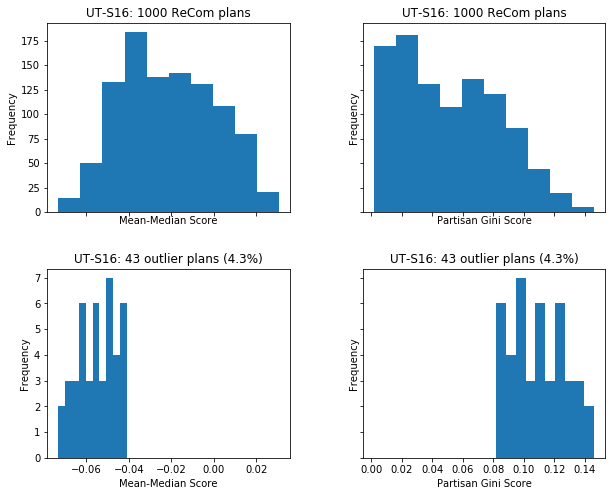

In [3]:
%%time
import os
from functools import partial
import json

import geopandas as gpd
import matplotlib.pyplot as plt
import networkx as nx
import pandas as pd
import numpy as np
from tqdm import tqdm_notebook

from gerrychain import (
    Election,
    Graph,
    MarkovChain,
    Partition,
    accept,
    constraints,
    updaters,
)

from gerrychain.metrics import efficiency_gap, mean_median, partisan_gini
from gerrychain.proposals import recom
from gerrychain.updaters import cut_edges
from gerrychain.tree import recursive_tree_part

# State specific information
state = "utah"
state_abrev = "UT"
num_dist = 4
# elections_dict = {"PRES16":"PRES16",
#                   "SEN16":"SEN16",
#                   "GOV16":"GOV16"}

# Reading in state data
graph_path = "./" + state + ".json"
graph = Graph.from_json(graph_path)
with open (graph_path, "r") as myfile:
    data=myfile.readlines()
graph_dict = json.loads(data[0])

# Calculating state population
pop = 0
for i in graph.nodes:
    pop += graph.nodes[i]["TOTPOP"]

# Updaters
my_updaters = {
    "population": updaters.Tally("TOTPOP", alias="population"),
    "cut_edges": cut_edges,
    "SEN16": Election("SEN16", {"democratic":"SEN16D","republican":"SEN16R"}),
    "PRES16": Election("SEN16", {"democratic":"PRES16D","republican":"PRES16R"}),
    "GOV16": Election("SEN16", {"democratic":"GOV16D","republican":"GOV16R"})
}

# Create an initial partition
new_plan = recursive_tree_part(graph,
                               range(num_dist),
                               pop/num_dist,
                               "TOTPOP",
                               0.05,
                               1)
initial_partition = Partition(graph,
                              new_plan,
                              my_updaters)

# Proposal specifications
proposal = partial(recom,
                   pop_col = "TOTPOP",
                   pop_target = pop/num_dist,
                   epsilon = 0.05,
                   node_repeats = 3)

compactness_bound = constraints.UpperBound(
    lambda p: len(p["cut_edges"]), 2 * len(initial_partition["cut_edges"])
)

# Running the chain
chain = MarkovChain(
    proposal=proposal,
    constraints=[
        constraints.within_percent_of_ideal_population(initial_partition, 0.2),
        compactness_bound,
    ],
    accept=accept.always_accept,
    initial_state=initial_partition,
    total_steps=1000,
)

# Collecting data from chain
SEN16triplets = []
PRES16triplets = []
GOV16triplets = []


for step in tqdm_notebook(chain):
    SEN16triplets.append([step["SEN16"].wins("republican"),
                     mean_median(step["SEN16"]),
                     partisan_gini(step["SEN16"])])
    PRES16triplets.append([step["PRES16"].wins("republican"),
                     mean_median(step["PRES16"]),
                     partisan_gini(step["PRES16"])])
    GOV16triplets.append([step["GOV16"].wins("republican"),
                     mean_median(step["GOV16"]),
                     partisan_gini(step["GOV16"])])
    
SEN16mm = []
SEN16pg = []
SEN16mm_winnowed = []
SEN16pg_winnowed = []
PRES16mm = []
PRES16pg = []
PRES16mm_winnowed = []
PRES16pg_winnowed = []
GOV16mm = []
GOV16pg = []
GOV16mm_winnowed = []
GOV16pg_winnowed = []

for triple in tqdm_notebook(SEN16triplets):
    SEN16mm.append(triple[1])
    SEN16pg.append(triple[2])
    if triple[0] > (np.mean(SEN16triplets, axis=0)[0] + 2*np.std(SEN16triplets, axis = 0)[0]) or triple[0] < (np.mean(SEN16triplets, axis=0)[0] - 2*np.std(SEN16triplets, axis = 0)[0]):
        SEN16mm_winnowed.append(triple[1])
        SEN16pg_winnowed.append(triple[2])
        
for triple in tqdm_notebook(PRES16triplets):
    PRES16mm.append(triple[1])
    PRES16pg.append(triple[2])
    if triple[0] > (np.mean(PRES16triplets, axis=0)[0] + 2*np.std(PRES16triplets, axis = 0)[0]) or triple[0] < (np.mean(PRES16triplets, axis=0)[0] - 2*np.std(PRES16triplets, axis = 0)[0]):
        PRES16mm_winnowed.append(triple[1])
        PRES16pg_winnowed.append(triple[2])

for triple in tqdm_notebook(GOV16triplets):
    GOV16mm.append(triple[1])
    GOV16pg.append(triple[2])
    if triple[0] > (np.mean(GOV16triplets, axis=0)[0] + 2*np.std(GOV16triplets, axis = 0)[0]) or triple[0] < (np.mean(GOV16triplets, axis=0)[0] - 2*np.std(GOV16triplets, axis = 0)[0]):
        GOV16mm_winnowed.append(triple[1])
        GOV16pg_winnowed.append(triple[2])

# Plotting data
fig, ax = plt.subplots(2,2, figsize=(10,8), sharex="col", sharey="row")

plt.subplots_adjust(wspace=0.3, hspace=0.3)

# Variables
bins_num = 10
bins_num_w = 10
title = "UT-S16: 1000 ReCom plans"
num_outliers = str(len(SEN16mm_winnowed))
pct_outliers = str(round(len(SEN16mm_winnowed) / 1000 * 100, 1))
title_w = "UT-S16: " + num_outliers + " outlier plans " + "(" + pct_outliers + "%)"

# Plotting the whole dataset
ax[0,0].hist(SEN16mm, bins=bins_num)
ax[0,1].hist(SEN16pg, bins=bins_num)

ax[0,0].set_title(title)
ax[0,0].set_ylabel("Frequency")
ax[0,0].set_xlabel("Mean-Median Score")

ax[0,1].set_title(title)
ax[0,1].set_ylabel("Frequency")
ax[0,1].set_xlabel("Partisan Gini Score")

# Plotting the winnowed data
ax[1,0].hist(SEN16mm_winnowed, bins=bins_num_w)
ax[1,1].hist(SEN16pg_winnowed, bins=bins_num_w)

ax[1,0].set_title(title_w)
ax[1,0].set_ylabel("Frequency")
ax[1,0].set_xlabel("Mean-Median Score")

ax[1,1].set_title(title_w)
ax[1,1].set_ylabel("Frequency")
ax[1,1].set_xlabel("Partisan Gini Score")